In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import os

Start:  0.0
End:  223175.0


C:\Users\jonas\AppData\Local\Temp\ipykernel_19788\1663247790.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[[data_sensor]] = scaler.transform(train[[data_sensor]])
C:\Users\jonas\AppData\Local\Temp\ipykernel_19788\1663247790.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[[data_sensor]] = scaler.transform(test[[data_sensor]])


Number of train sequences: 17293
Number of test sequences: 4015


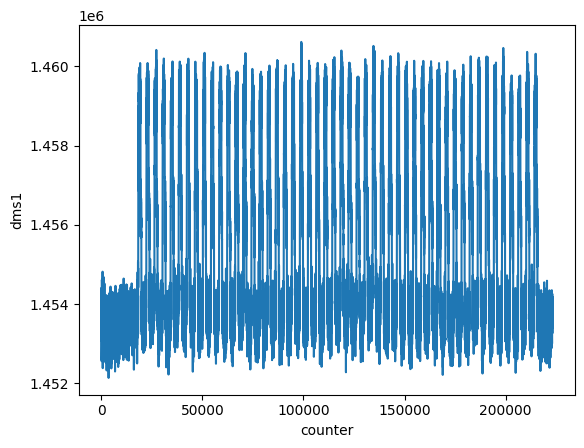

In [3]:
# TODO input from console for test, change index averaging, fix fluctuation and input data 

# Read env variables
# data_path = os.getenv('DATA_FILE')
# data_sensor = os.getenv('DATA_SENSOR')
# supervised_mode = os.getenv('SUPERVISED_MODE')
# target_rec_loss = float(os.getenv('TARGET_REC_LOSS'))
# seq_size = int(os.getenv('SEQ_SIZE'))
# factor = int(os.getenv('FACTOR'))

data_path = 'data/fl_data.csv'
data_sensor = 'dms1'
supervised_mode = True
threshhold = 0
seq_size = 500
factor = 3

# How do I get the data? env variable from docker compose?
dataframe = pd.read_csv(data_path, delimiter=';')
df = dataframe[['counter', data_sensor]]

df = df.groupby(df.index // 10).agg({
    'counter': 'first',
    data_sensor: 'mean',
}).reset_index(drop=True)

sns.lineplot(x=df['counter'], y=df[data_sensor])

print("Start: ", df['counter'].min())
print("End: ", df['counter'].max())

# approx 80/20 split
train, test = df.loc[df['counter'] <= 178000], df.loc[df['counter'] > 178000]

# print(train.shape)

scaler = StandardScaler()
scaler = scaler.fit(train[[data_sensor]])

train[[data_sensor]] = scaler.transform(train[[data_sensor]])
test[[data_sensor]] = scaler.transform(test[[data_sensor]])

def to_sequences(x, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size - 100):
        x_values.append(x.iloc[i:(i + seq_size)].values)
        y_values.append(x.iloc[i + 100:(i + 100 + seq_size)].values)
        
    return np.array(x_values), np.array(y_values)

# shape: (samples, seq_size, n_features)
trainX, trainY = to_sequences(train[[data_sensor]], seq_size)
# shape: (samples, n_features)
testX, testY = to_sequences(test[[data_sensor]], seq_size)

num_train_sequences = len(train) - seq_size
num_test_sequences = len(test) - seq_size

print(f"Number of train sequences: {num_train_sequences}")
print(f"Number of test sequences: {num_test_sequences}")

# print(trainX.shape)
# print(trainY.shape)

trainX = torch.tensor(trainX, dtype=torch.float32)
trainY = torch.tensor(trainY, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
testY = torch.tensor(testY, dtype=torch.float32)

train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.lstm1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.lstm2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=2,
          dropout=0.5,
          batch_first=True
        )

    def forward(self, x):
        #print('enc:', x.shape)

        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)

        return x

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=128, output_dim=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, output_dim

        self.lstm1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=2,
          dropout=0.5,
          batch_first=True
        )

        self.lstm2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.dense_layers = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        #print('dec1:', x.shape)
        x, (hidden_n, cell_n) = self.lstm1(x)
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = x[:,-1,:]
        #print('dec2:', x.shape)

        return self.dense_layers(x)
    
class LSTMAutoencoder(nn.Module):
    def __init__(self, device, seq_len, n_features, embedding_dim=128, output_dim=1):
        super(LSTMAutoencoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, output_dim).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.unsqueeze(-1)
        # print('LSTMAE: ', x.shape)

        return x

In [41]:
def train(device, model, train_dl, n_epochs=16):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    epoch_losses = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X, Y in train_dl:
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl) 
        epoch_losses.append(train_loss) 
        print(f'Epoch {epoch+1}, Loss: {train_loss}')

    # training loss
    epochs = range(1, n_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, epoch_losses, marker='o', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()


def detect(model, test_dl, device, supervised_mode=False):
    model.eval()
    criterion = nn.MSELoss()
    reconstruction_errors = []
    actual_data = []
    pred_data = []

    with torch.no_grad():
        for x, y in test_dl:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = criterion(output, y)
            reconstruction_error = loss.item()
            reconstruction_errors.append(reconstruction_error)

            actual_data.extend(y[:, -100:].cpu().numpy().flatten())
            pred_data.extend(output[:, -100:].cpu().numpy().flatten())


    actual_data = np.array(actual_data)
    pred_data = np.array(pred_data)
    counter = np.arange(1, len(actual_data) + 1)

    plt.figure(figsize=(14, 7))
    sns.lineplot(x=counter, y=actual_data, color='blue', label='Actual Data')
    sns.lineplot(x=counter, y=pred_data, color='red', label='Predicted Data', alpha=0.6)
    plt.xlabel('Counter')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Data Points')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 7))
    sns.lineplot(x=counter[:5000], y=actual_data[:5000], color='blue', label='Actual Data')
    sns.lineplot(x=counter[:5000], y=pred_data[:5000], color='red', label='Predicted Data')
    plt.xlabel('Counter')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Data Points')
    plt.legend()
    plt.grid(True)
    plt.show()


    if supervised_mode:
        mean_error = np.mean(reconstruction_errors)
        std_error = np.std(reconstruction_errors)
        os.environ['threshold'] = str(mean_error + factor * std_error)
        return mean_error + factor * std_error
    else:
        anomalies = []
        for err in reconstruction_errors:
            if err > threshhold:
                anomalies.append(err)
        return len(anomalies)
    

Epoch 1, Loss: 0.9631264392549663
Epoch 2, Loss: 0.6908936880002677
Epoch 3, Loss: 0.5386867154403469
Epoch 4, Loss: 0.3539641553944593
Epoch 5, Loss: 0.23180027043647705
Epoch 6, Loss: 0.21480302372774226
Epoch 7, Loss: 0.19328694230423318
Epoch 8, Loss: 0.1695296480406948
Epoch 9, Loss: 0.1335186206053624
Epoch 10, Loss: 0.09371279108729283
Epoch 11, Loss: 0.07776196711250065
Epoch 12, Loss: 0.07329617077865565
Epoch 13, Loss: 0.07443985753246067
Epoch 14, Loss: 0.0686968294903636
Epoch 15, Loss: 0.06441586909877987
Epoch 16, Loss: 0.06306370104694234
Epoch 17, Loss: 0.06427482952498814
Epoch 18, Loss: 0.06252383574718769
Epoch 19, Loss: 0.05884808309196207
Epoch 20, Loss: 0.05806974574688088


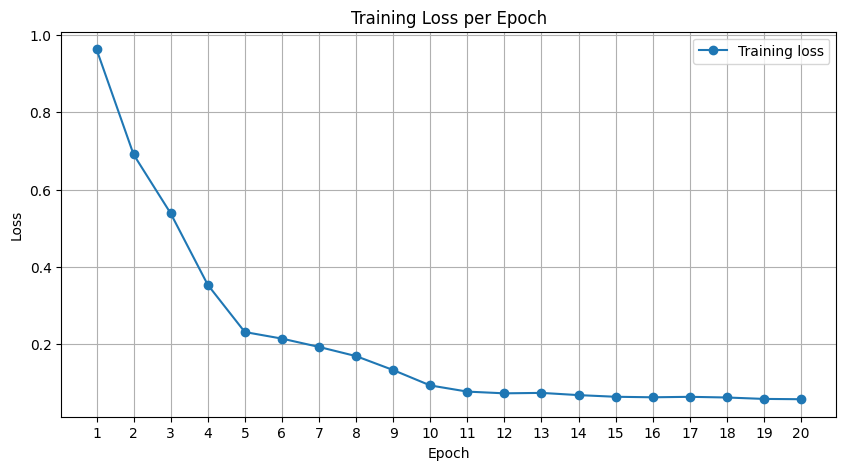

Threshhold: 0.6883117326525574


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMAutoencoder(device, seq_len=trainX.shape[1], n_features=trainX.shape[2], output_dim=seq_size).to(device)

train(device, model, train_dl)

if supervised_mode:
    threshold = detect(model, test_dl, device, supervised_mode)
    print(f'Threshhold: {threshold}')
else:
    anomaly_score = detect(model, test_dl, device, supervised_mode)
    print(f'Anomalies Detected: {anomaly_score}')

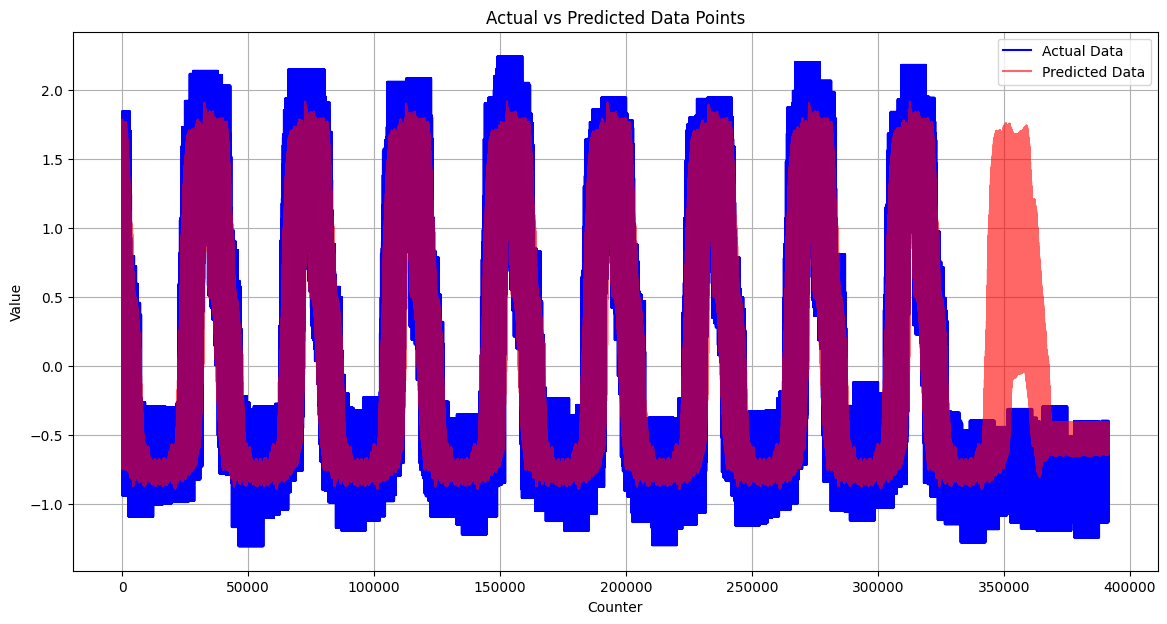

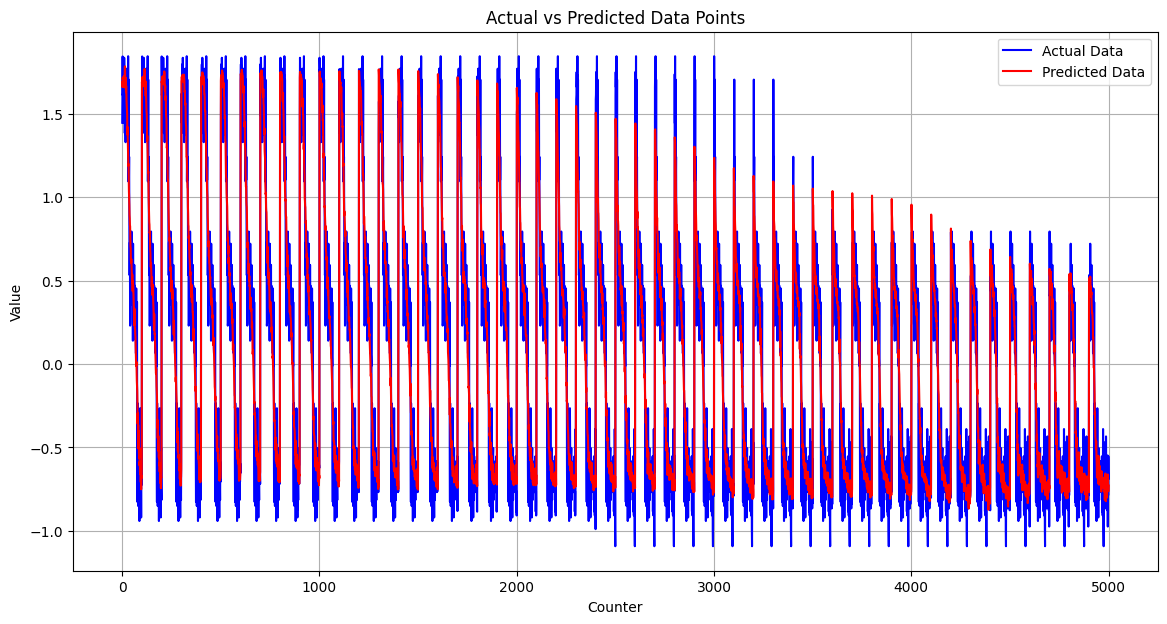

Threshhold: 0.6883117326525574


In [42]:
threshold = detect(model, test_dl, device, supervised_mode)
print(f'Threshhold: {threshold}')